# 05_Xarray_CFSR_TimeLoop

<img src="http://xarray.pydata.org/en/stable/_static/dataset-diagram-logo.png" align="center" width="30%">

## Overview
1. Select a date and access various CFSR Datasets
1. Specify a date/time range, and subset the desired Datasets along their dimensions
1. Perform unit conversions
1. Use a `for` loop to create a well-labeled sequence of multi-parameter plots of gridded CFSR reanalysis data

## Imports

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
from datetime import datetime as dt
from metpy.units import units
import metpy.calc as mpcalc
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

# <span style="color:purple">1) Specify a starting and ending date/time, and access several CFSR Datasets</span>

In [1]:
# Date/Time specification
startYear = 1993
startMonth = 3
startDay = 13
startHour = 0
startMinute = 0
startDateTime = dt(startYear,startMonth,startDay, startHour, startMinute)

endYear = 1993
endMonth = 3
endDay = 14
endHour = 18
endMinute = 0
endDateTime = dt(endYear,endMonth,endDay, endHour, endMinute)


NameError: name 'dt' is not defined

### Create Xarray `Dataset` objects, each pointing to their respective NetCDF files in the `/cfsr/data` directory tree, using Xarray's [open_dataset](http://xarray.pydata.org/en/stable/generated/xarray.open_dataset.html) method.

In [3]:
dsZ = xr.open_dataset (f'/cfsr/data/{startYear}/g.{startYear}.0p5.anl.nc')
dsT = xr.open_dataset (f'/cfsr/data/{startYear}/t.{startYear}.0p5.anl.nc')
dsU = xr.open_dataset (f'/cfsr/data/{startYear}/u.{startYear}.0p5.anl.nc')
dsV = xr.open_dataset (f'/cfsr/data/{startYear}/v.{startYear}.0p5.anl.nc')
dsW = xr.open_dataset (f'/cfsr/data/{startYear}/w.{startYear}.0p5.anl.nc')
dsQ = xr.open_dataset (f'/cfsr/data/{startYear}/q.{startYear}.0p5.anl.nc')
dsSLP = xr.open_dataset (f'/cfsr/data/{startYear}/pmsl.{startYear}.0p5.anl.nc')

<div class="alert alert-warning">Note: A current limitation is that the time range cannot span multiple years.</div>

## Specify a date/time range, and subset the desired `Dataset`s along their dimensions.

### We will use the `sel` method on the latitude and longitude dimensions as well as time and isobaric surface.

We have already specified the date and time up above; let's use that for the initial time, but now also specify a range of times that we can loop over.

#### Create a list of date and times based on what we specified for the initial and final times, using Pandas' `date_range` function

In [4]:
dateList = pd.date_range(startDateTime, endDateTime,freq="6H")
dateList

DatetimeIndex(['1993-03-13 00:00:00', '1993-03-13 06:00:00',
               '1993-03-13 12:00:00', '1993-03-13 18:00:00',
               '1993-03-14 00:00:00', '1993-03-14 06:00:00',
               '1993-03-14 12:00:00', '1993-03-14 18:00:00'],
              dtype='datetime64[ns]', freq='6H')

In [5]:
# Areal extent
lonW = -100
lonE = -60
latS = 20
latN = 50
cLat, cLon = (latS + latN)/2, (lonW + lonE)/2
#latRange = np.arange(latS-5,latN+5,.5) # expand the data range a bit beyond the plot range
#lonRange = np.arange((lonW-5),(lonE+5),.5) # Need to match longitude values to those of the coordinate variable
latRange = np.arange(latS,latN+.5,.5) # expand the data range a bit beyond the plot range
lonRange = np.arange(lonW,lonE+.5,.5) # Need to match longitude values to those of the coordinate variable

# Vertical level specificaton
plevel = 850
levelStr = str(plevel) # Use for the figure title


# Data variable selection; modify depending on what variables you are interested in

T = dsT['t'].sel(time=dateList,lev=plevel,lat=latRange,lon=lonRange)
U = dsU['u'].sel(time=dateList,lev=plevel,lat=latRange,lon=lonRange)
V = dsV['v'].sel(time=dateList,lev=plevel,lat=latRange,lon=lonRange)



### Let's look at some of the attributes

In [6]:
T.time

<xarray.DataArray 'time' (time: 8)>
array(['1993-03-13T00:00:00.000000000', '1993-03-13T06:00:00.000000000',
       '1993-03-13T12:00:00.000000000', '1993-03-13T18:00:00.000000000',
       '1993-03-14T00:00:00.000000000', '1993-03-14T06:00:00.000000000',
       '1993-03-14T12:00:00.000000000', '1993-03-14T18:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1993-03-13 ... 1993-03-14T18:00:00
    lev      float32 850.0
Attributes:
    actual_range:  [1691808. 1700562.]
    last_time:     1993-12-31 18:00:00
    first_time:    1993-1-1 00:00:00
    delta_t:       0000-00-00 06:00:00
    long_name:     initial time

In [7]:
T.units

'K'

In [8]:
U.units

'm s^-1'

In [9]:
V.units

'm s^-1'

#### Define our subsetted coordinate arrays of lat and lon. Pull them from any of the DataArrays. We'll need to pass these into the contouring functions later on.

In [10]:
lats = T.lat
lons = T.lon

## Perform unit conversions

#### We take the DataArrays and apply [MetPy's unit conversion method](https://unidata.github.io/MetPy/latest/tutorials/xarray_tutorial.html#units).

In [11]:
T = T.metpy.convert_units('degC')
U = U.metpy.convert_units('kts')
V = V.metpy.convert_units('kts')

# <span style="color:purple"> 4) Use a `for` loop to create a well-labeled sequence of multi-parameter plots of gridded CFSR reanalysis data</span>

#### Now define the range of our contour values and a contour interval. 
This of course will depend on the level, time, region, and variable.

In [18]:
minTVal = -30
maxTVal = 24
cint = 2
Tcintervals = np.arange(minTVal, maxTVal, cint)
Tcintervals

array([-30, -28, -26, -24, -22, -20, -18, -16, -14, -12, -10,  -8,  -6,
        -4,  -2,   0,   2,   4,   6,   8,  10,  12,  14,  16,  18,  20,
        22])

## Loop over the range of times and plot the map.

In this example: filled contours of 850 hPa temperature and wind barbs.

<div class="alert alert-warning">Note: in the Jupyter notebook, the contents of your <i><font color="blue">for</i></font> loop must be in a <b><font color="blue">single cell</b></font>.</div>

#### Place lines that don't vary with each iteration of the loop in their own cell, outside the loop.

In [19]:
constrainLat, constrainLon = (0.7, 6.5)
proj_map = ccrs.LambertConformal(central_longitude=cLon, central_latitude=cLat)
proj_data = ccrs.PlateCarree()
res = '50m'

Processing 1993-03-13 00:00:00
Processing 1993-03-13 06:00:00
Processing 1993-03-13 12:00:00
Processing 1993-03-13 18:00:00
Processing 1993-03-14 00:00:00
Processing 1993-03-14 06:00:00
Processing 1993-03-14 12:00:00
Processing 1993-03-14 18:00:00


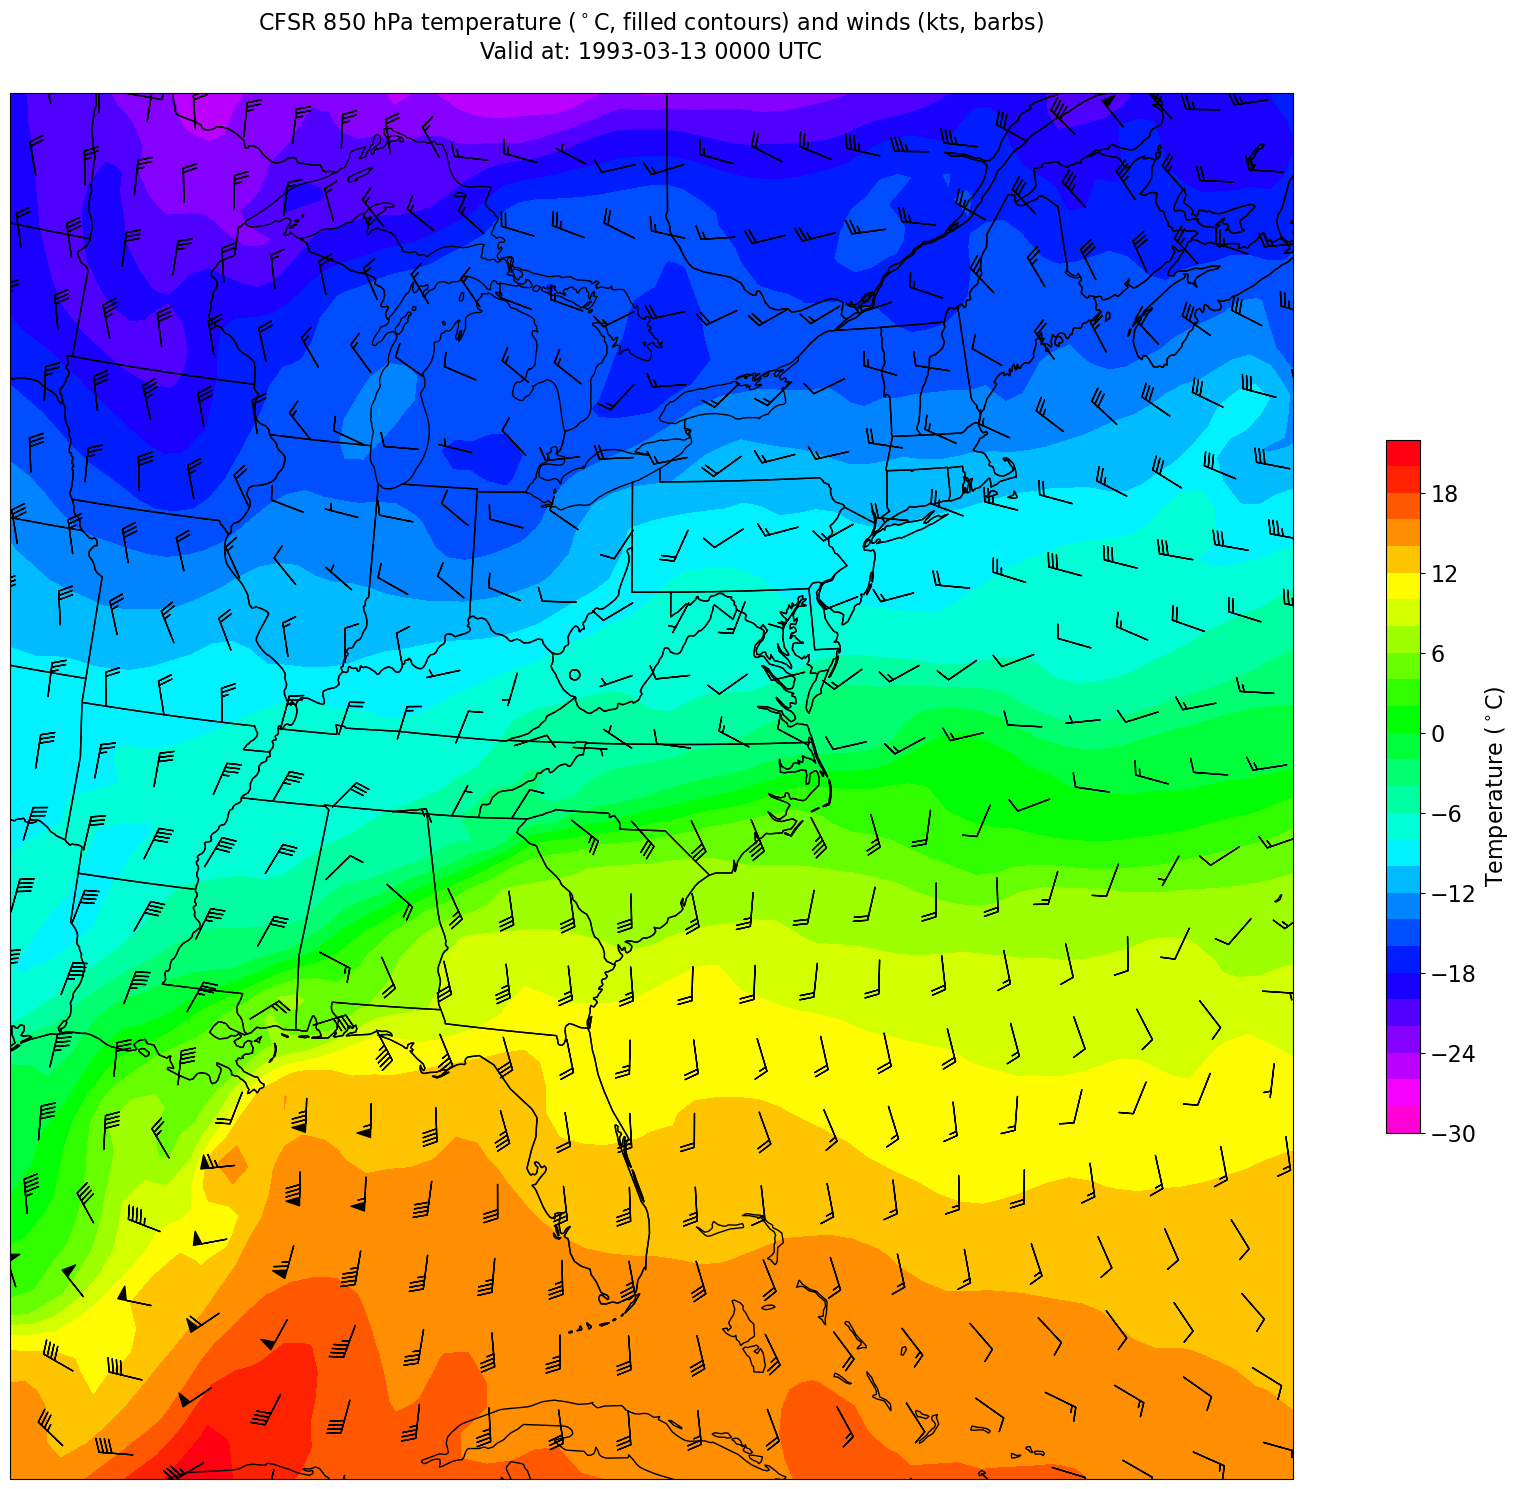

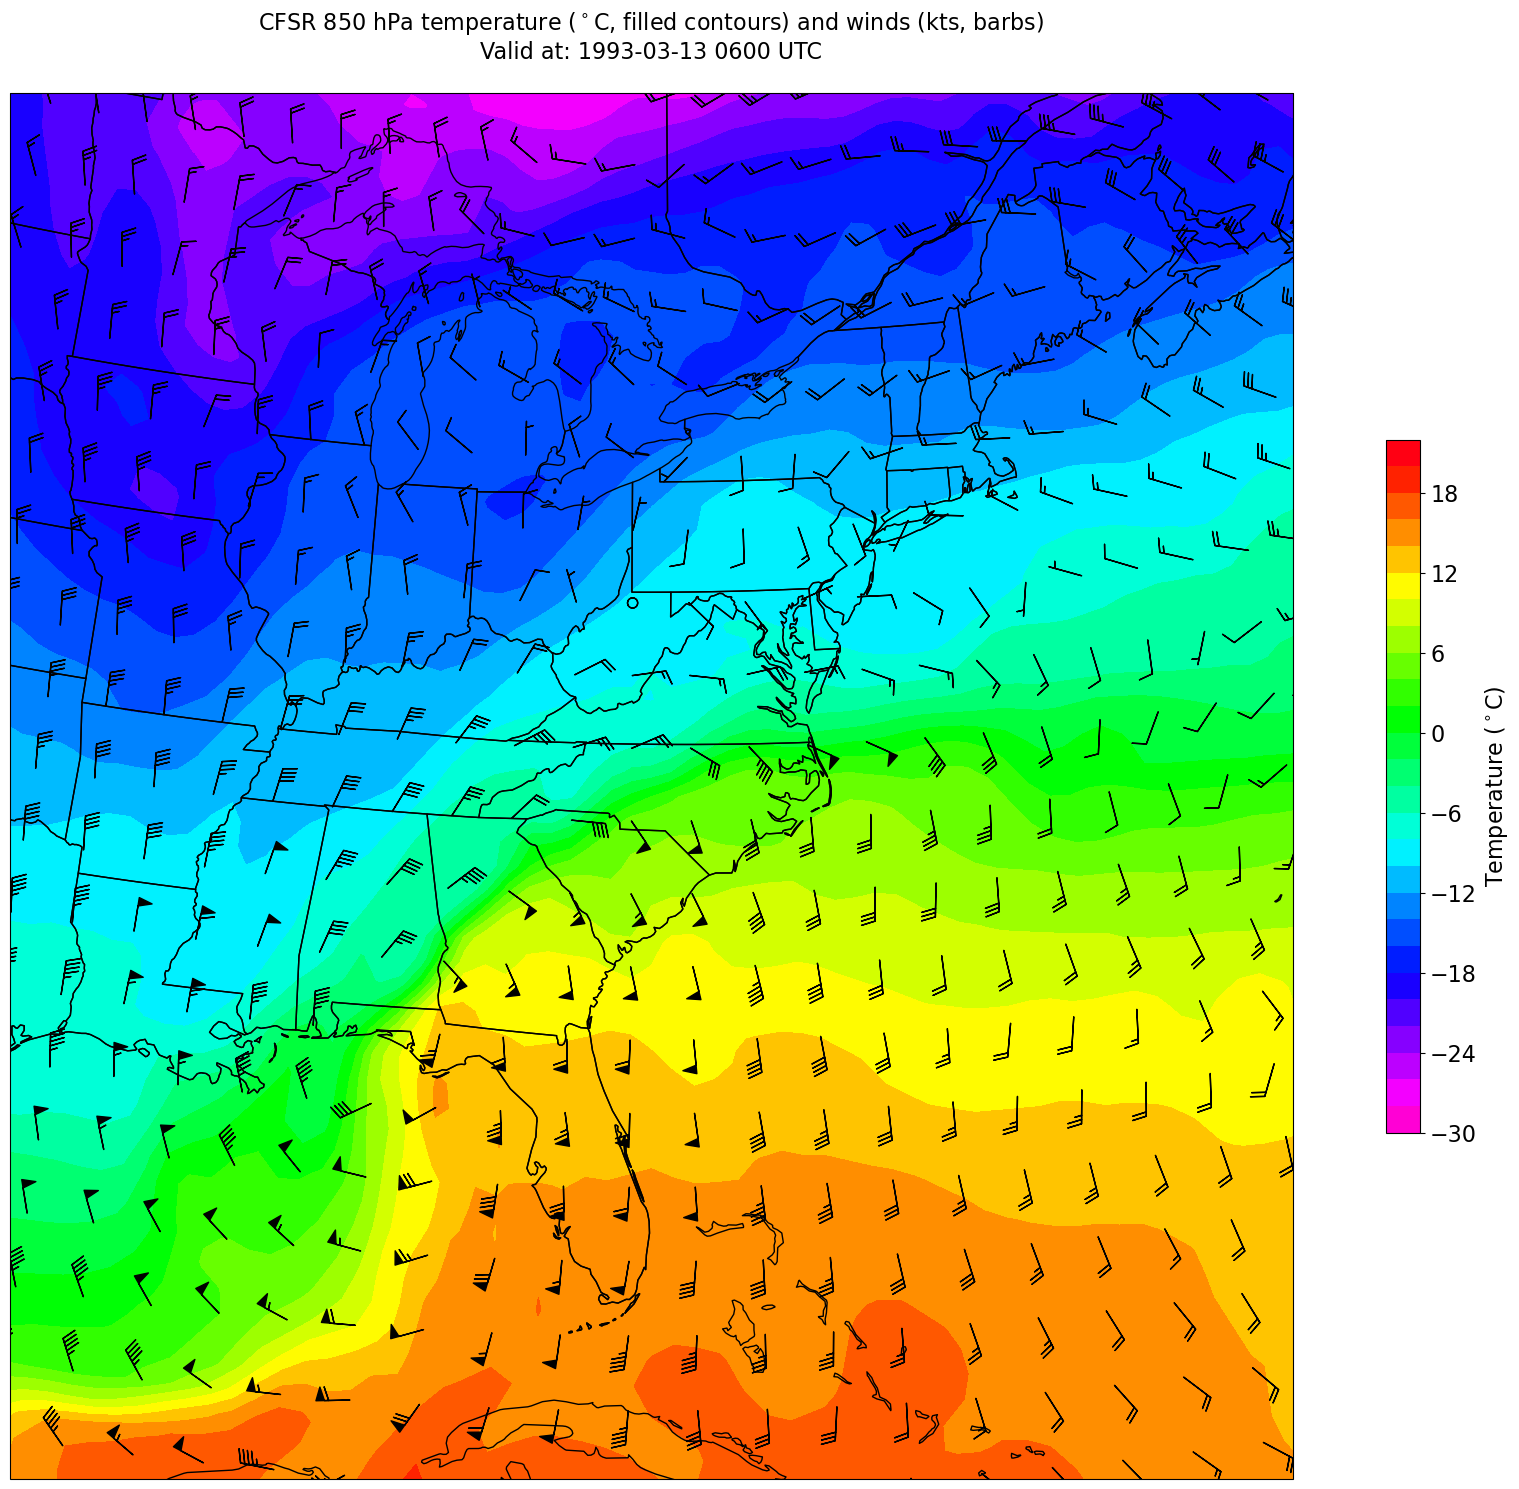

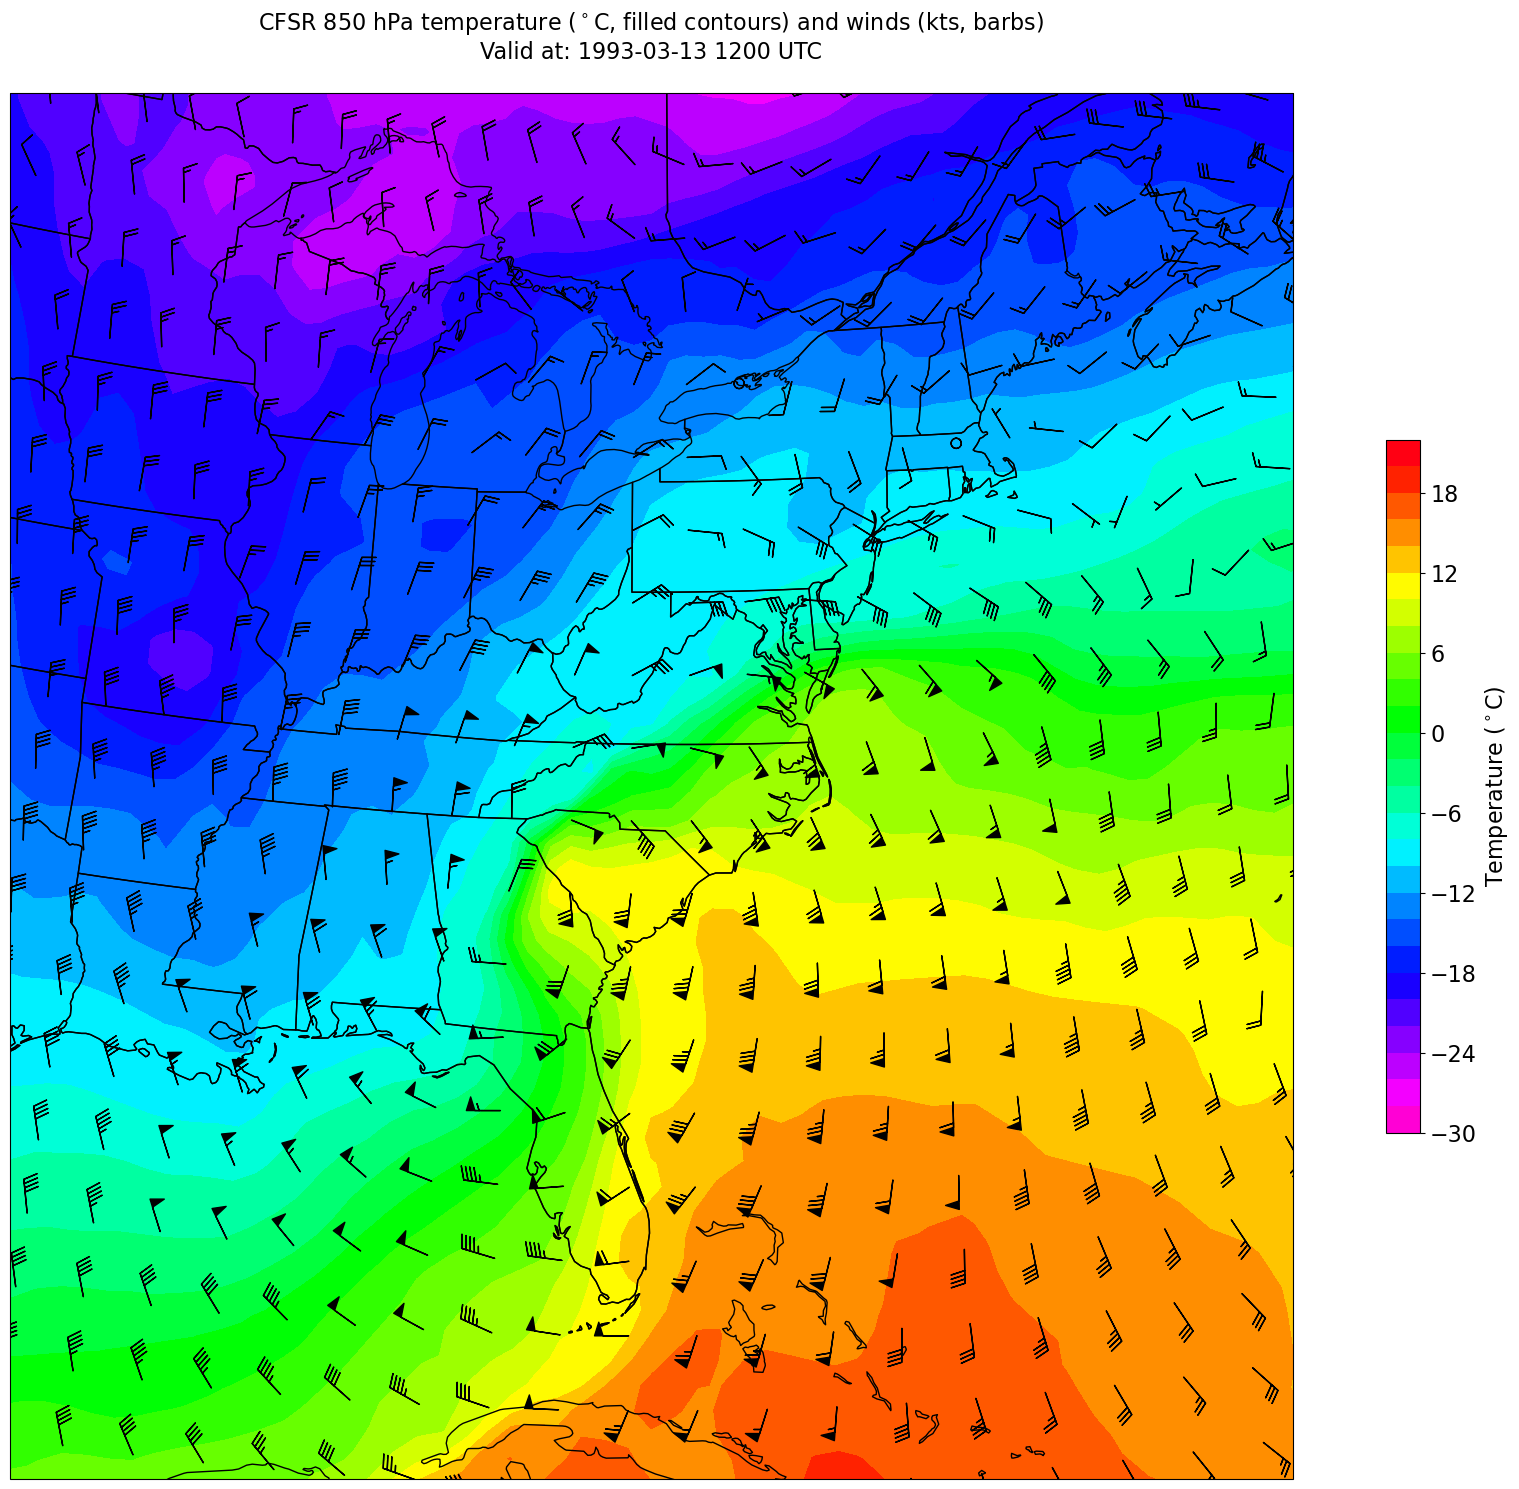

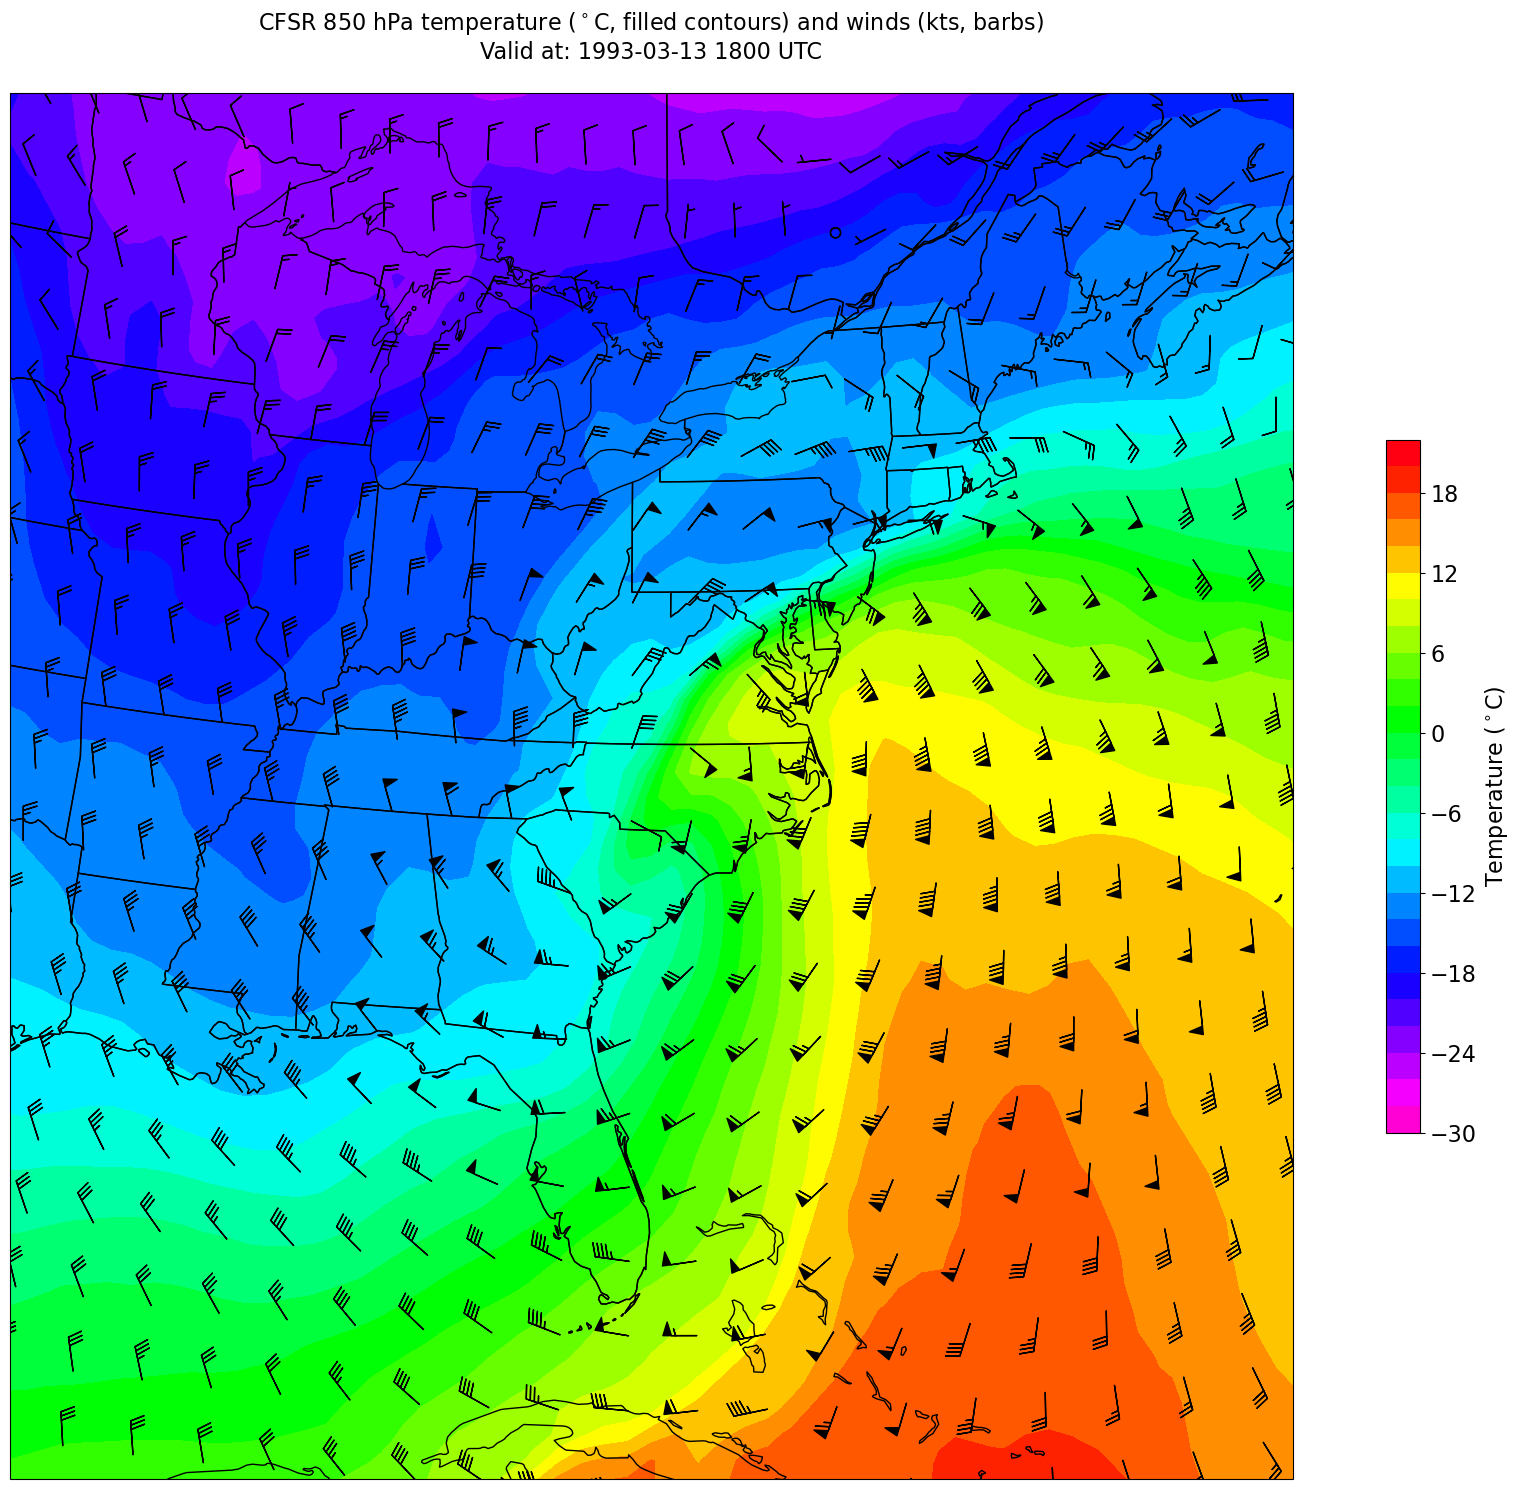

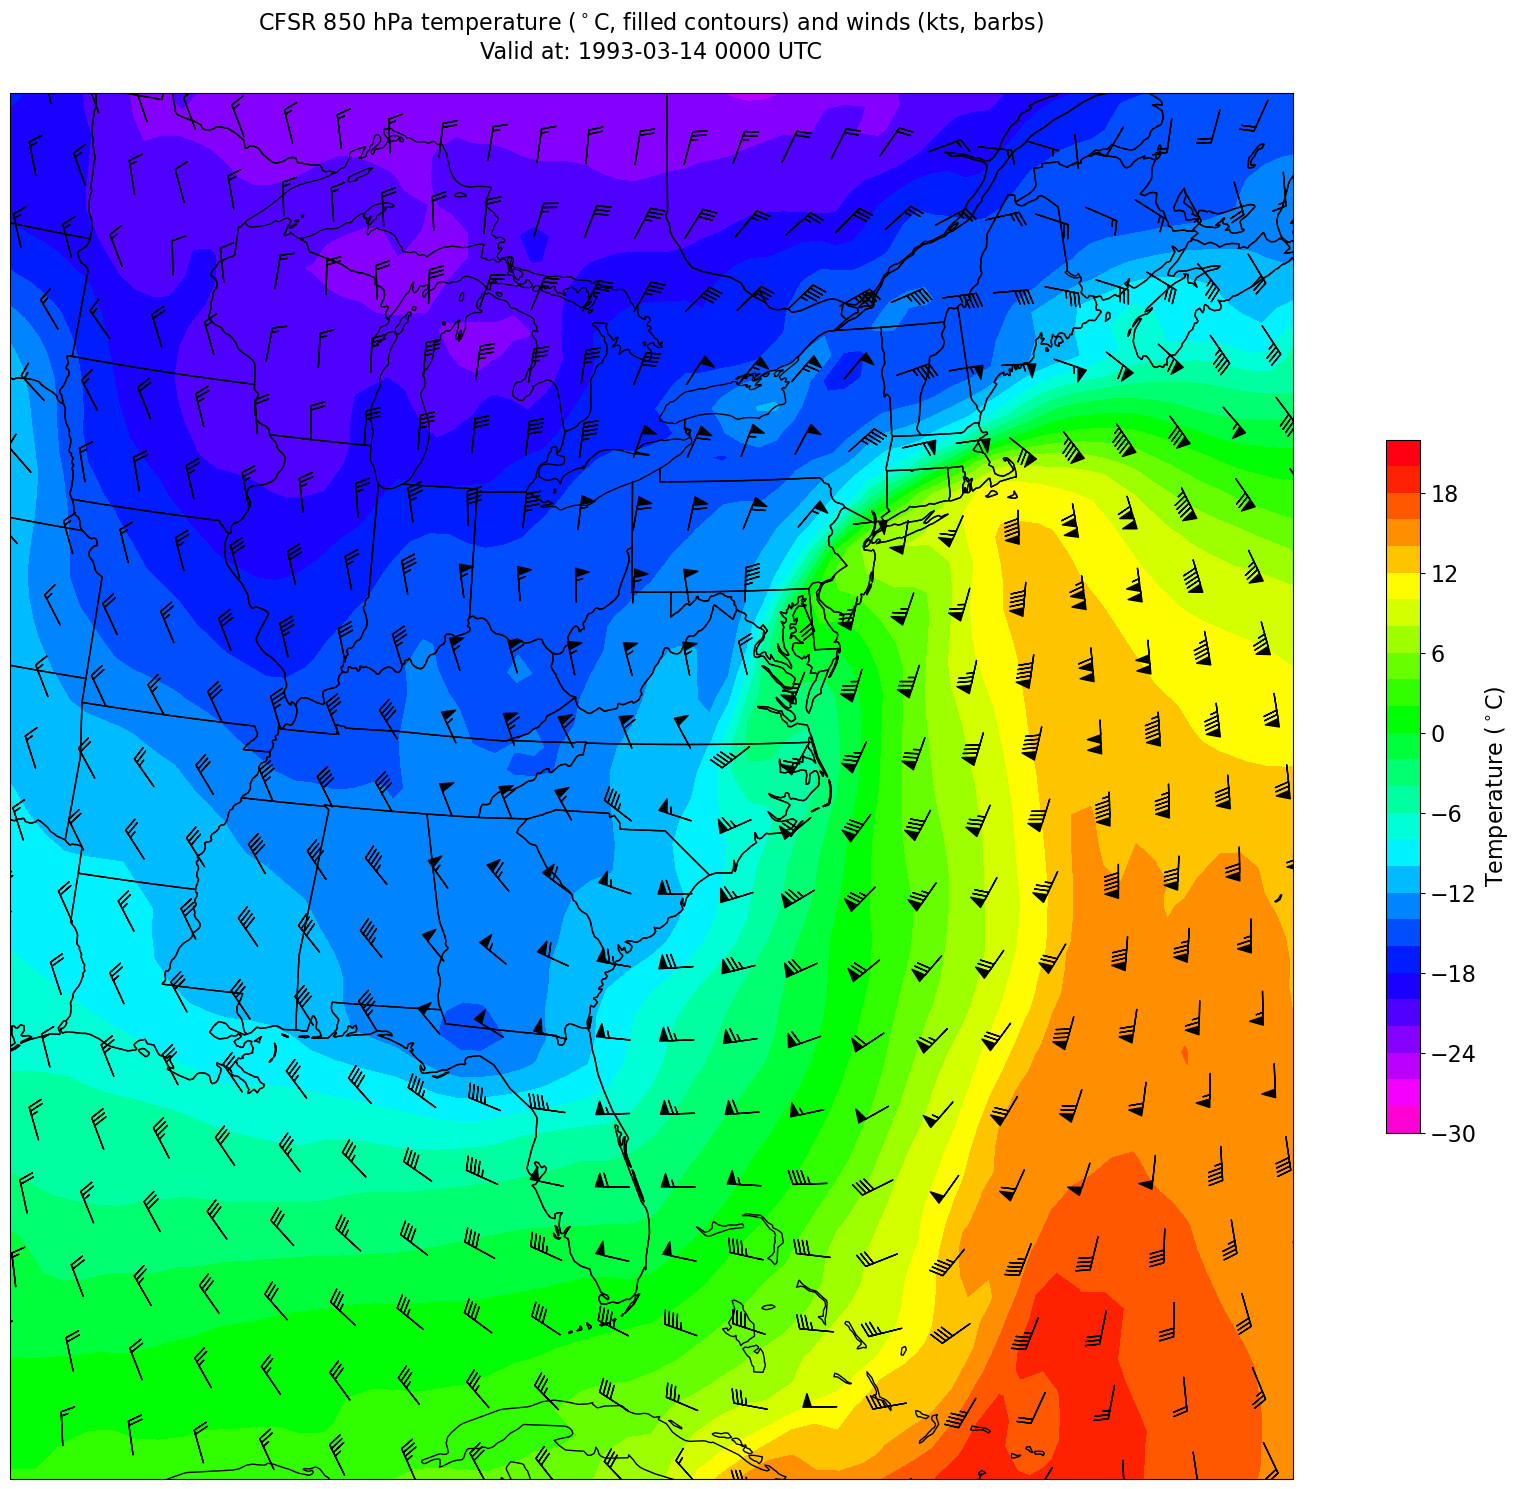

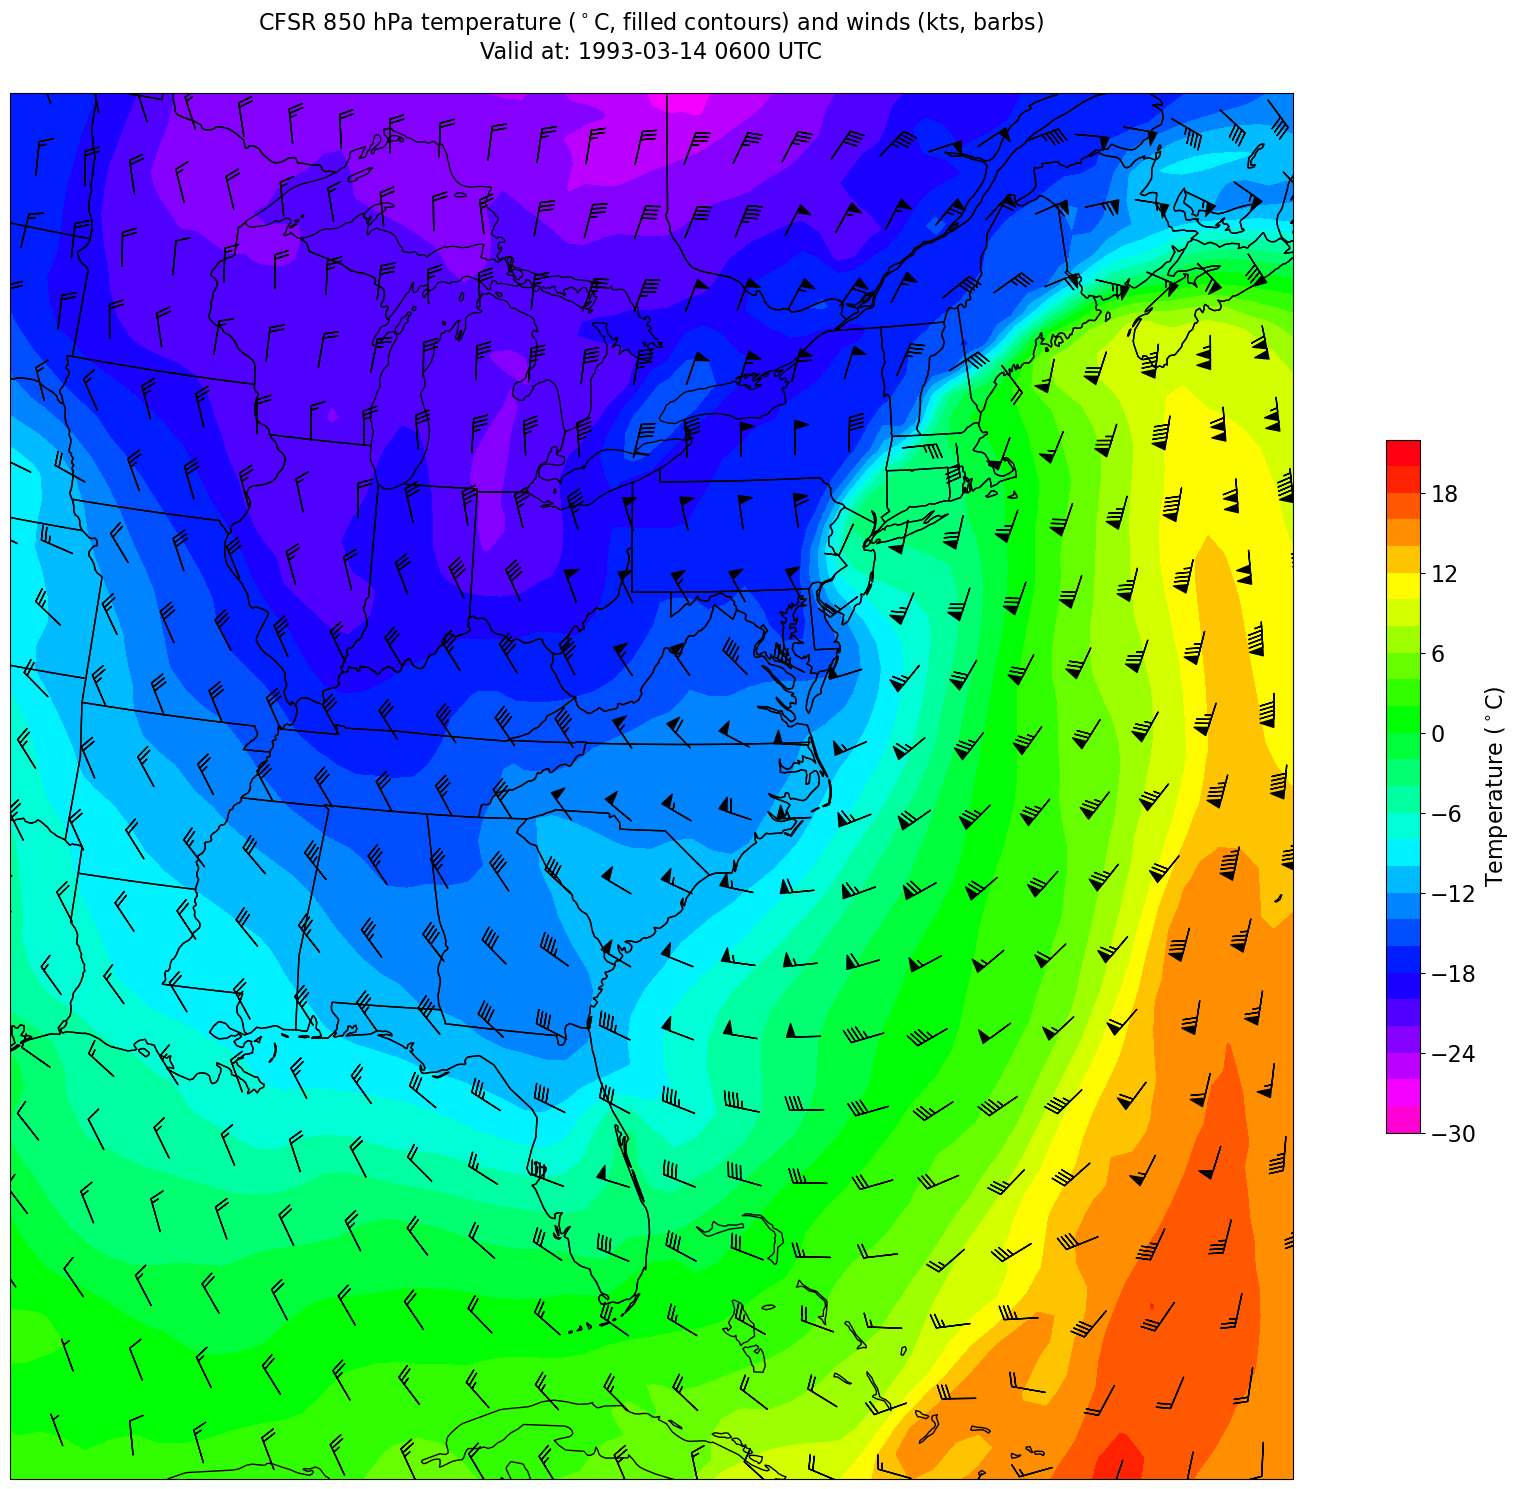

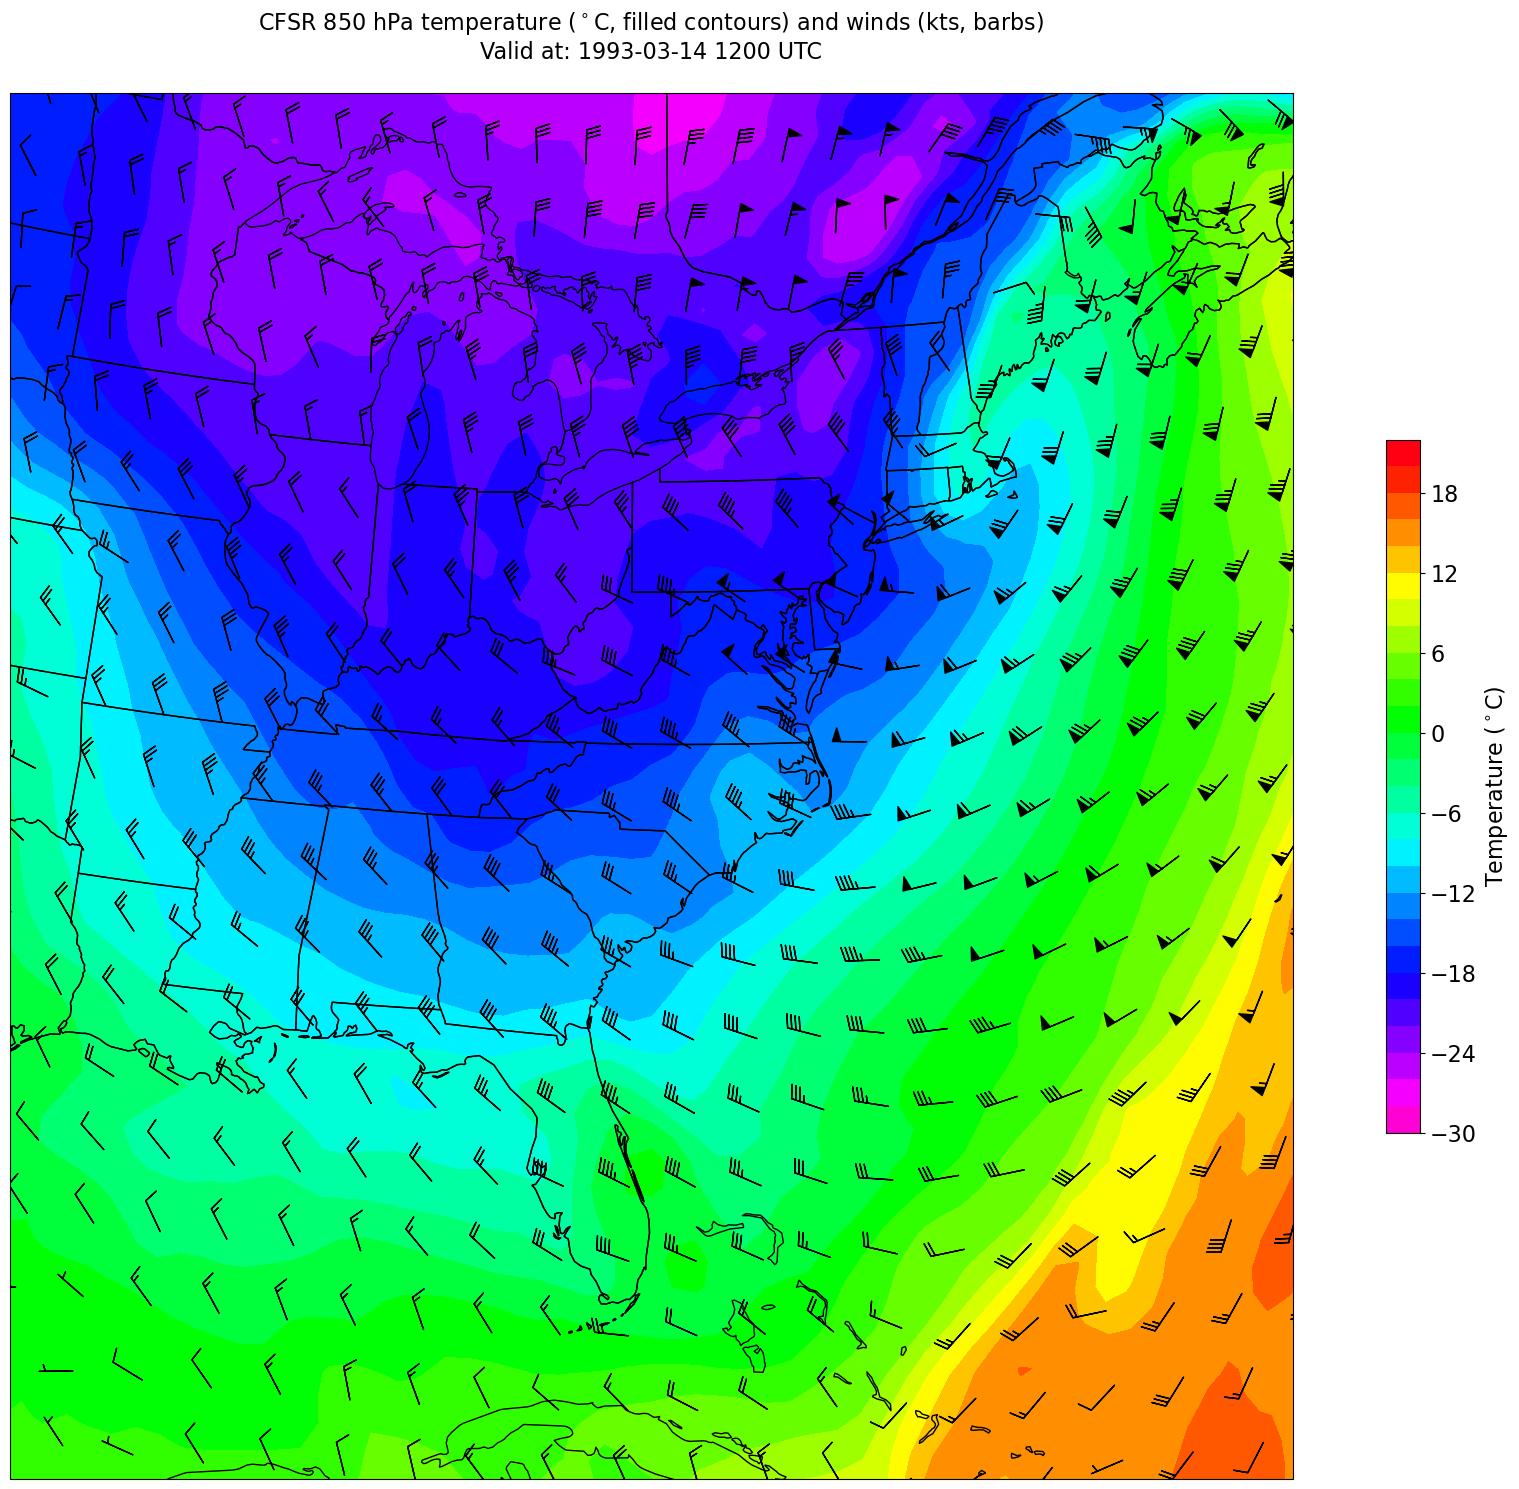

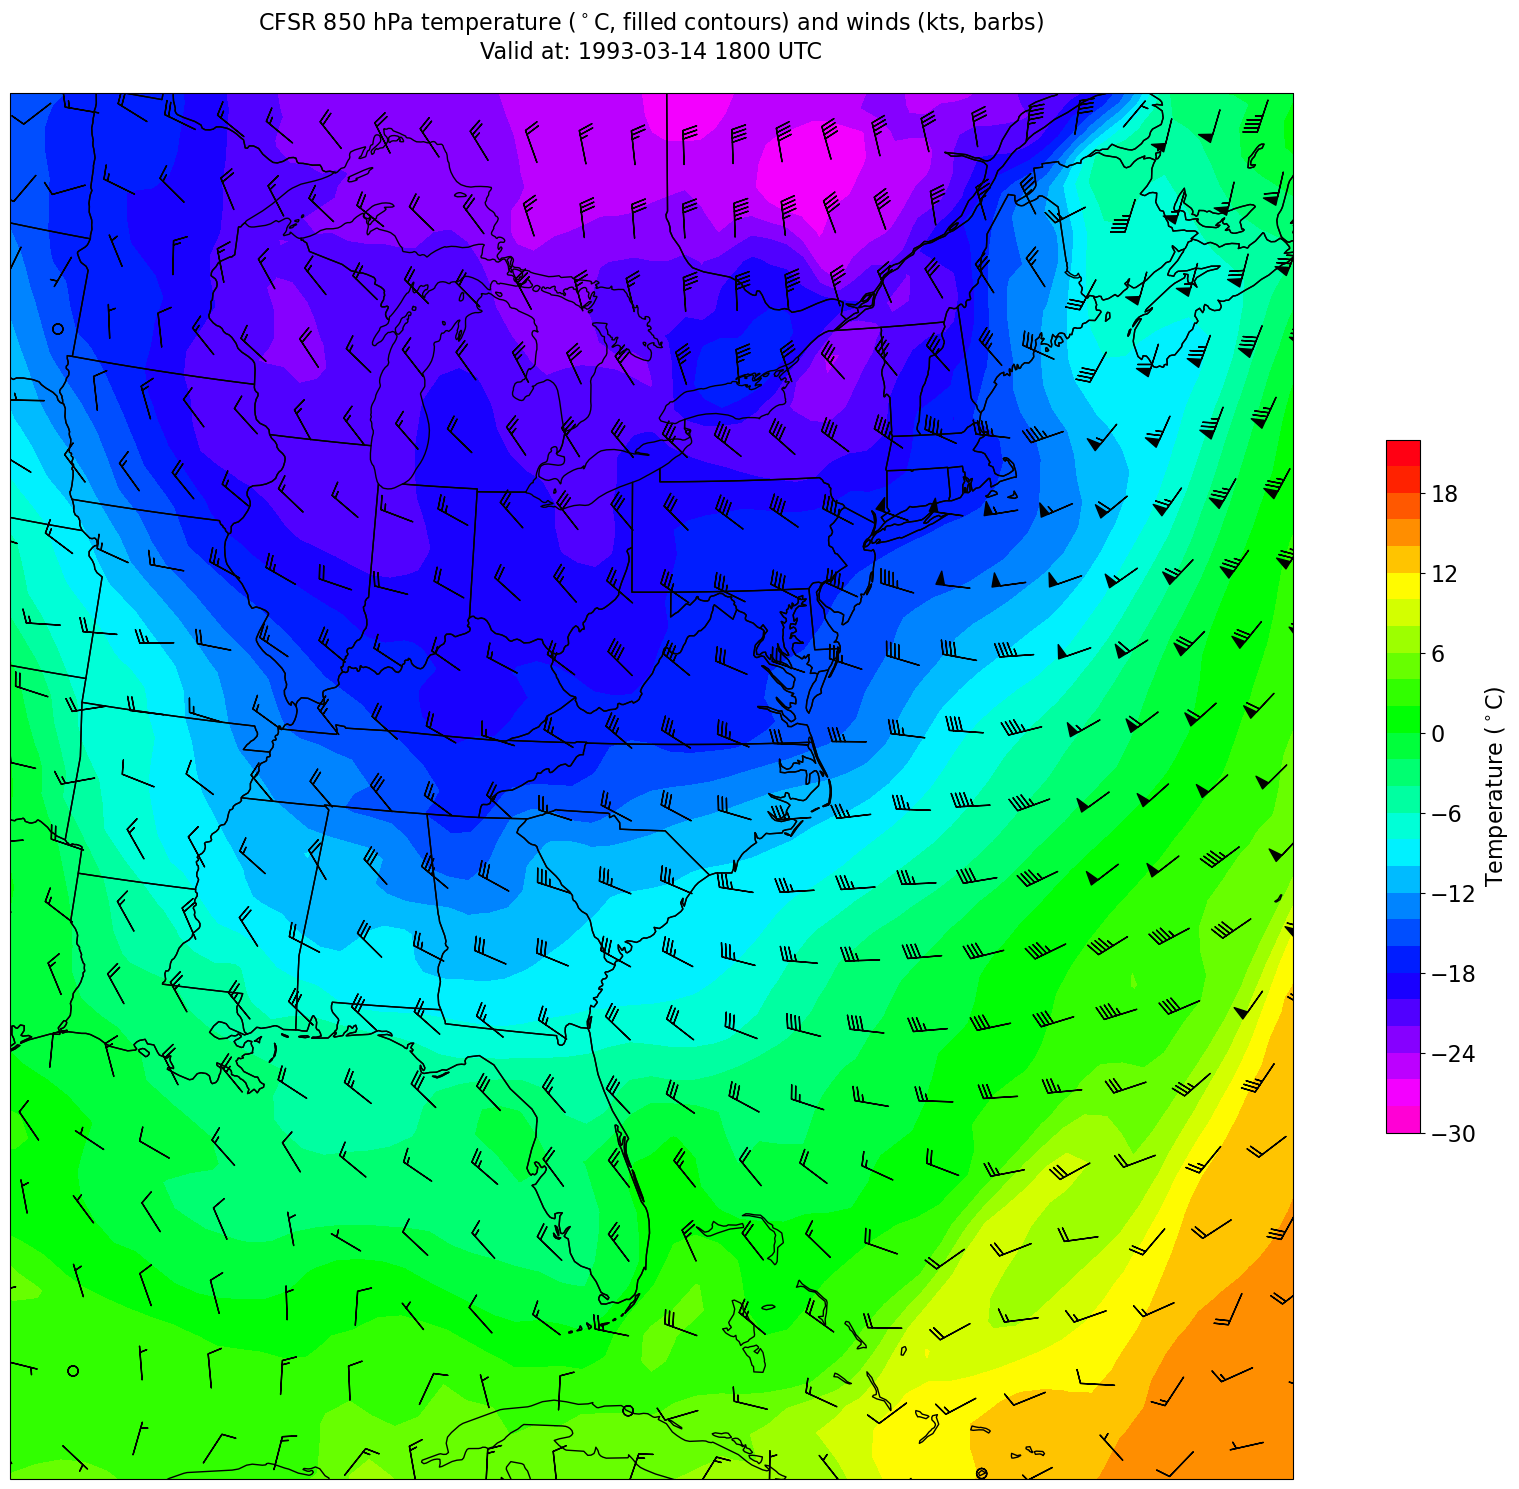

In [22]:
for time in dateList:
    print("Processing", time)
    
    # Create the time strings, for the figure title as well as for the file name.
    timeStr = dt.strftime(time,format="%Y-%m-%d %H%M UTC")
    timeStrFile = dt.strftime(time,format="%Y%m%d%H")
    
    tl1 = "CFSR " + levelStr + " hPa temperature ($^\circ$C, filled contours) and winds (kts, barbs)"
    tl2 = str('Valid at: '+ timeStr)
    title_line = (tl1 + '\n' + tl2 + '\n')
    
    fig = plt.figure(figsize=(24,18)) # Increase size to adjust for the constrained lats/lons
    ax = plt.subplot(1,1,1,projection=proj_map)
    ax.set_extent ([lonW+constrainLon,lonE-constrainLon,latS+constrainLat,latN-constrainLat])
    ax.add_feature(cfeature.COASTLINE.with_scale(res))
    ax.add_feature(cfeature.STATES.with_scale(res))
    
    # Need to use Xarray's sel method here to specify the current time for any DataArray you are plotting.
    CF = ax.contourf(lons,lats,T.sel(time=time), levels=Tcintervals,transform=proj_data,cmap='gist_rainbow_r') #prism
#    CF = ax.contourf(lons,lats,T, levels=Tcintervals,transform=proj_data,cmap='gist_rainbow_r')
    cbar = plt.colorbar(CF,shrink=0.5)
    cbar.ax.tick_params(labelsize=16)
    cbar.ax.set_ylabel("Temperature ($^\circ$C)",fontsize=16)

    # Plotting wind barbs uses the ax.barbs method. Here, you can't pass in the DataArray directly; you can only pass in the array's values.
    # Also need to sample (skip) a selected # of points to keep the plot readable.
    # Remember to use Xarray's sel method here as well to specify the current time.
    skip = 3
    ax.barbs(lons[::skip],lats[::skip],U.sel(time=time)[::skip,::skip].values, V.sel(time=time)[::skip,::skip].values, transform=proj_data)

    title = plt.title(title_line,fontsize=16)
    
    #Generate a string for the file name and save the graphic to your current directory.
    fileName = timeStrFile + '_CFSR_' + levelStr + '_T_Wind.png'
    fig.savefig(fileName)